$\Huge AS4501$

Transformers and Attention

Francisco Förster

Bibliography:

* [Attention is all you need, Vaswani et al. 2017](https://arxiv.org/pdf/1706.03762.pdf)
* https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html (many figures from this great website)
* https://towardsdatascience.com/attention-and-transformer-models-fe667f958378

# Motivation

Recurrent neural networks have two big problems:

1. They tend to give too much weight to recent elements in a sequence, but sometimes the most important connections in a sentence are separated by a large number of elements.

2. They are intrinsically serial in nature. We need to process a sequence in order to compute the output of a RNN.

This is how a RNN processes a sentence, paying more attention to the last word at each step and requiring a serial processing:

![](images/sentence-classification-rnn.png)

But in many cases the last word is not the most important, and we would like to be able to process each word and its association with other words in parallel:

![](images/sentence-example-attention.png)

This also happens in the problem of translation:

![](images/sentence.png)

# Softmax

Let's remember the softmax function applied to a vector x:

$\Large {\rm softmax(x_i)} = \frac{\exp{x_i}}{\sum\limits_j \exp{x_j}}$ 

This function returns ~1 at the largest value of the vector and ~0 elsewhere.

![](images/softmax.png)

# Attention mechanism

The attention mechanism is an approach in deep learning that allows models to focus on different parts of the input when producing the output. Instead of focusing in some hidden state like in RNNs, in attention each output explicitly depends on all previous input states, weighted by attention scores.

For example in this sentence with the following attention scores:

 I love travelling
   
   [0.1,  0.2,  0.7] ---> J'adore
  
  [0.5,  0.5,  0.0] ---> voyager

'J'adore' pays more attention or has more affinity to 'travelling' as the next word when translating.

'voyager' pays attention to 'I' and 'love' equally when translating.

# Self-attention

Self Attention, also known as intra Attention, is an attention mechanism that relates different positions of one sequence in order to compute a representation of the same sequence. 

![](images/intraattention.png)

In a self-attention layer, an input matrix $X$ ($n$ tokens of dimension $d$) are turned it into an output matrix $Z$ ($n$ components of dimension $d_v$) via three representational matrices of the input:

* queries Q
* keys K
* values V

$\Large {\rm Attention}(Q, K, V) = {\rm softmax}( Q \cdot K^T / \sqrt{d_k}) * V$

where $Q$, $K$ and $V$ are matrices representing linear transformations from the input vector $x$ via learnable parameters $W^Q$, $W^K$ and $W^V$:

* $Q = X W^Q$
* $K = X W^K$
* $V = X W^V$

Note that 
* $x \in \mathbb{R}^{n \times d}$
* $Q \in \mathbb{R}^{n \times d_k}$
* $K \in \mathbb{R}^{n \times d_k}$
* $V \in \mathbb{R}^{n \times d_v}$
* $W^Q \in \mathbb{R}^{d \times d_k}$
* $W^K \in \mathbb{R}^{d \times d_k}$
* $W^V \in \mathbb{R}^{d_v \times d}$

![](images/attention_detail.png)

![](images/selfattention_summary.png)

# Cross-attention

One can generalize the previous computation for combining two input matrices $X_1$ and $X_2$:

![](images/cross-attention-summary.png)

And this is an example of a cross attention matrix:

![](images/bahdanau-fig3.png)

and a visualization of one row

![](images/attention.png)

# Multi-head attention

In multi-head attention we concatenate the output from several heads $i$ with learnable parameters $W_i^Q$, $W_i^K$ and $W_i^V$, and then linearly transform this vector with learnable parameters $W^O$:

$\Large {\rm Multihead} = {\rm concat}({\rm head}_1, ... {\rm head}_h) W^O$

![](images/multi-head.png)

# Positional encodings

One problem with the previous strategy is that the order of the input is never used to compute the attention scores. In order to fix this problem, information about the relative positions of the inputs must be added. In the original paper by Vaswani they use sine and cosine functions of different frequencies:

* $PE(pos, 2i) = sin(pos / 10000^{2i/d})$
* $PE(pos, 2i) = cos(pos / 10000^{2i/d})$

![](images/PE.png)

In other works, a set of functions are learned as the positional encoder. For example, in [Pimentel+2023](https://arxiv.org/pdf/2201.08482.pdf) they use the following function (timeFiLM):

![](images/timefilm.png)
![](images/timefilm2.png)

# Transformers

The full transformer arquitecture proposed by Vaswani et al. 2017 is the following:

![](images/transformer.png)

The model is composed of an encoder and a decoder. 

The encoder is composed of 6 identical layers, each one with two sublayers: a multi-head self-attention mechanism and a position wise fully connected feed-forward network. The output of each sublayer uses a residual connection (we add the input to the output of the sublayer), which helps with convergence, and is normalized using layer normalization.

The decoder is also composed of 6 identical layers. In addition to the two sublayers used in the encoder, a sublayer is added in between that uses multihead cross attention with the output of the encoder. The multihead self-attention is also modified to mask positions that have not been visited by the decoder (predictions for position i can depend only on the known outputs of positions less than i).



# Examples

## Training synthetic light curves 

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# === Synthetic Astronomical Dataset ===
class LightCurveDataset(Dataset):
    def __init__(self, n_samples=1000, seq_len=100):
        self.data = []
        self.labels = []
        self.seq_len = seq_len

        for _ in range(n_samples):
            if np.random.rand() < 0.5:
                # Periodic variable (class 0)
                freq = np.random.uniform(0.1, 0.5)
                time = np.linspace(0, 10, seq_len)
                mag = np.sin(2 * np.pi * freq * time) + 0.1 * np.random.randn(seq_len)
                label = 0
            else:
                # Irregular variable (class 1)
                mag = np.cumsum(np.random.randn(seq_len)) * 0.1
                label = 1

            self.data.append(mag)
            self.labels.append(label)

        self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(-1)  # shape: (N, L, 1)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [14]:
# === Main Training Script ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = LightCurveDataset(n_samples=2000)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

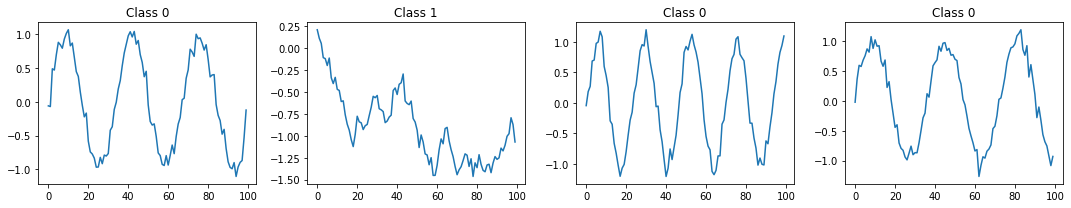

In [15]:
def plot_samples(dataset, num=4):
    fig, axs = plt.subplots(1, num, figsize=(15, 3))
    for i in range(num):
        x, y = dataset[i]
        axs[i].plot(x.squeeze().numpy())
        axs[i].set_title(f"Class {y.item()}")
    plt.tight_layout()
    plt.show()

plot_samples(dataset)


In [16]:
# === Transformer Model ===
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (B, L, 1)
        x = self.input_proj(x)            # (B, L, d_model)
        x = self.transformer(x)           # (B, L, d_model)
        x = x.mean(dim=1)                 # global average pooling
        return self.classifier(x)

# === Training Setup ===
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)

In [17]:
model = TransformerClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    loss, acc = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


Epoch 1: Loss = 0.2247, Accuracy = 0.8990
Epoch 2: Loss = 0.0443, Accuracy = 0.9900
Epoch 3: Loss = 0.0124, Accuracy = 0.9975
Epoch 4: Loss = 0.0086, Accuracy = 0.9985
Epoch 5: Loss = 0.0138, Accuracy = 0.9975
Epoch 6: Loss = 0.0059, Accuracy = 0.9990
Epoch 7: Loss = 0.0174, Accuracy = 0.9970
Epoch 8: Loss = 0.0042, Accuracy = 0.9995
Epoch 9: Loss = 0.0014, Accuracy = 1.0000
Epoch 10: Loss = 0.0009, Accuracy = 1.0000


## Vision transformers

This is based on the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
](https://arxiv.org/abs/2010.11929)

![](images/vit.png)

See https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb
    

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [19]:
class SyntheticAstronomyImageDataset(Dataset):
    def __init__(self, n_samples=1000, img_size=64):
        self.images = []
        self.labels = []
        self.img_size = img_size

        for _ in range(n_samples):
            label = np.random.randint(0, 2)
            if label == 0:
                # Star-like: central Gaussian blob
                x = self._gaussian_blob(center=True)
            else:
                # Galaxy-like: off-center or elliptical
                x = self._gaussian_blob(center=False)
            self.images.append(x)
            self.labels.append(label)

        self.images = torch.tensor(self.images, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def _gaussian_blob(self, center=True):
        x = np.zeros((self.img_size, self.img_size))
        cx = cy = self.img_size // 2 if center else np.random.randint(10, self.img_size - 10)
        X, Y = np.meshgrid(np.arange(self.img_size), np.arange(self.img_size))
        x = np.exp(-((X - cx) ** 2 + (Y - cy) ** 2) / (2 * (5 + np.random.rand())**2))
        x += np.random.normal(0, 0.05, x.shape)
        return x

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=8, emb_dim=128, img_size=64):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches + 1, emb_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)                         # (B, emb_dim, H', W')
        x = x.flatten(2).transpose(1, 2)         # (B, N_patches, emb_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, emb_dim)
        x = torch.cat([cls_tokens, x], dim=1)    # (B, N_patches + 1, emb_dim)
        x = x + self.pos_embed
        return x

In [21]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=64, patch_size=8, emb_dim=128, num_layers=4, num_heads=4, num_classes=2):
        super().__init__()
        self.patch_embed = PatchEmbedding(1, patch_size, emb_dim, img_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.transformer(x)
        cls_token_out = x[:, 0]  # only use the [CLS] token
        return self.mlp_head(cls_token_out)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = SyntheticAstronomyImageDataset(n_samples=2000)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

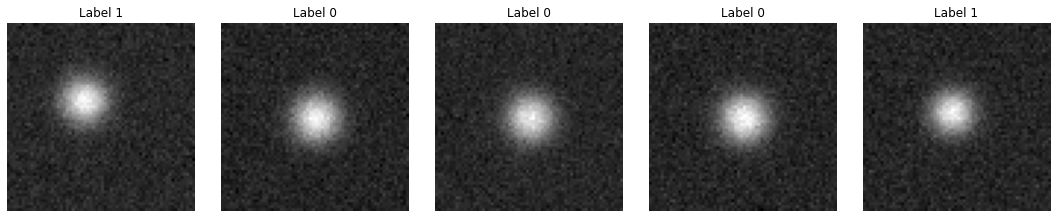

In [26]:
def plot_examples(dataset, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        img, label = dataset[i]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(f"Label {label.item()}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_examples(dataset)

In [24]:
model = VisionTransformer(
    img_size=64,
    patch_size=4,
    emb_dim=64,
    num_layers=2,
    num_heads=2,
    num_classes=2
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

for epoch in range(20):
    model.train()
    total_loss, total_correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
    scheduler.step()
    print(f"Epoch {epoch+1}: Loss={total_loss/len(dataset):.4f}, Acc={total_correct/len(dataset):.4f}")

Epoch 1: Loss=0.7134, Acc=0.5175
Epoch 2: Loss=0.6946, Acc=0.5175
Epoch 3: Loss=0.6888, Acc=0.5555
Epoch 4: Loss=0.4171, Acc=0.8940
Epoch 5: Loss=0.3173, Acc=0.9430
Epoch 6: Loss=0.3290, Acc=0.9330
Epoch 7: Loss=0.2972, Acc=0.9525
Epoch 8: Loss=0.2949, Acc=0.9550
Epoch 9: Loss=0.2796, Acc=0.9610
Epoch 10: Loss=0.2880, Acc=0.9585
Epoch 11: Loss=0.2740, Acc=0.9640
Epoch 12: Loss=0.2635, Acc=0.9715
Epoch 13: Loss=0.2527, Acc=0.9745
Epoch 14: Loss=0.2539, Acc=0.9745
Epoch 15: Loss=0.2524, Acc=0.9735
Epoch 16: Loss=0.2488, Acc=0.9775
Epoch 17: Loss=0.2406, Acc=0.9830
Epoch 18: Loss=0.2419, Acc=0.9820
Epoch 19: Loss=0.2459, Acc=0.9795
Epoch 20: Loss=0.2470, Acc=0.9785
